# NDVI
We will use Intake and satsearch to find and download Sentinel-2 data from the
earth-search.aws.element84.com STAC API for our spatial extent. We will then compute
the Normalized Difference Vegetation Index (NDVI) for the scene.

In [ ]:
import geopandas as gpd
import rioxarray as rxr  # noqa: F401
import stackstac
from pystac_client import Client

In [ ]:
spatial_extent_filepath = "../data/raw/spatial-extent.gpkg"
orthophoto_metadata_filepath = "../data/raw/ortofoto-50cm-v7r0-metadades"
stac_url = "https://earth-search.aws.element84.com/v0"
stac_collection = "sentinel-s2-l2a-cogs"
stac_epsg = "4326"
max_cloud_cover = 10
dst_filepath = "../data/processed/ndvi.tif"

In [ ]:
spatial_extent_gdf = gpd.read_file(spatial_extent_filepath)
orthophoto_metadata_gdf = gpd.read_file(orthophoto_metadata_filepath)

In [ ]:
# spatial_extent_gdf.to_crs(orthophoto_metadata_gdf.crs).sjoin(
#     orthophoto_metadata_gdf
# ).plot()
dates_gdf = orthophoto_metadata_gdf.to_crs(spatial_extent_gdf.crs).sjoin(
    spatial_extent_gdf
)
date_start = dates_gdf["DATA_INICI"].min()
date_end = dates_gdf["DATA_FI"].max()
# bbox = spatial_extent_gdf.to_crs(stac_crs).total_bounds

In [ ]:
geom = spatial_extent_gdf.to_crs(epsg=stac_epsg)["geometry"].iloc[0]
results = Client.open(stac_url).search(
    collections=[stac_collection], intersects=geom, datetime=f"{date_start}/{date_end}"
)

In [ ]:
items = results.get_all_items()
# print(len(items))

In [ ]:
da = stackstac.stack(items, assets=["B04", "B08"])
ds = da[da["eo:cloud_cover"] < max_cloud_cover].to_dataset(dim="band")
# ds = stackstac.stack(items, assets=["B04", "B08"]).to_dataset(dim="band")
ds = ds.drop([coord for coord in ds.coords if coord not in ["time", "x", "y"]])
ds

/home/martibosch/mambaforge/envs/greenspace-accessibility-sabadell/lib/python3.10/site-packages/stackstac/prepare.py:363: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


<xarray.Dataset>
Dimensions:  (time: 3, y: 20982, x: 10980)
Coordinates:
  * time     (time) datetime64[ns] 2022-05-12T10:49:39 ... 2022-05-17T10:49:46
  * x        (x) float64 4e+05 4e+05 4e+05 ... 5.097e+05 5.097e+05 5.098e+05
  * y        (y) float64 4.7e+06 4.7e+06 4.7e+06 ... 4.49e+06 4.49e+06 4.49e+06
Data variables:
    B04      (time, y, x) float64 dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B08      (time, y, x) float64 dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
Attributes:
    spec:        RasterSpec(epsg=32631, bounds=(399960.0, 4490220.0, 509760.0...
    crs:         epsg:32631
    transform:   | 10.00, 0.00, 399960.00|\n| 0.00,-10.00, 4700040.00|\n| 0.0...
    resolution:  10.0

In [ ]:
ds = ds.rio.write_crs()
ds = ds.rio.clip(spatial_extent_gdf.to_crs(ds.rio.crs)["geometry"])
ds

<xarray.Dataset>
Dimensions:      (time: 3, x: 1056, y: 1133)
Coordinates:
  * time         (time) datetime64[ns] 2022-05-12T10:49:39 ... 2022-05-17T10:...
  * x            (x) float64 4.196e+05 4.196e+05 ... 4.301e+05 4.301e+05
  * y            (y) float64 4.606e+06 4.606e+06 ... 4.594e+06 4.594e+06
    spatial_ref  int64 0
Data variables:
    B04          (time, y, x) float64 dask.array<chunksize=(1, 806, 88), meta=np.ndarray>
    B08          (time, y, x) float64 dask.array<chunksize=(1, 806, 88), meta=np.ndarray>
Attributes:
    spec:        RasterSpec(epsg=32631, bounds=(399960.0, 4490220.0, 509760.0...
    transform:   | 10.00, 0.00, 399960.00|\n| 0.00,-10.00, 4700040.00|\n| 0.0...
    resolution:  10.0

In [ ]:
# compute ndvi and load it into memory
ndvi_da = (ds["B08"] - ds["B04"]) / (ds["B08"] + ds["B04"]).compute()
ndvi_da

<xarray.DataArray (time: 3, y: 1133, x: 1056)>
dask.array<truediv, shape=(3, 1133, 1056), dtype=float64, chunksize=(1, 806, 968), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 2022-05-12T10:49:39 ... 2022-05-17T10:...
  * x            (x) float64 4.196e+05 4.196e+05 ... 4.301e+05 4.301e+05
  * y            (y) float64 4.606e+06 4.606e+06 ... 4.594e+06 4.594e+06
    spatial_ref  int64 0

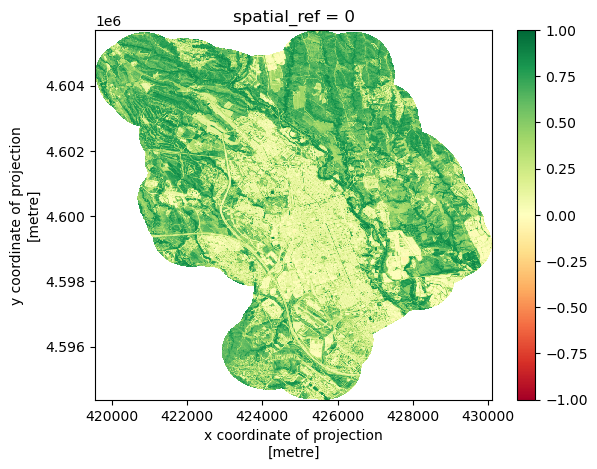

In [ ]:
# get the temporal mean
ndvi_da = ndvi_da.mean(dim="time")
ndvi_da.plot.imshow(cmap="RdYlGn", vmin=-1, vmax=1)

In [ ]:
# dump it to a geotiff
ndvi_da.rio.to_raster(dst_filepath)